In [1]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
skip_training = True  # Flag to skip training cells if interested only in plotting saved learning curves
cross_type = "in2out" # in2out, out2in
dst_path = "./dataset" # dataset dir previously downloaded
log_dir = "logs" # learning curve dir
ckpt_dir = "checkpoints" # best saved model

In [3]:
# ===================== GLOBAL CONSTANTS =====================

img_height   = 32
img_width    = 32
img_channels = 2
img_total    = img_height * img_width * img_channels


# ===================== ADAPTER MODULE =====================

class ConvAdapter(nn.Module):
    """
    Lightweight residual adapter:
        x ↦ x + Up(LeakyReLU(Down(x)))

    - channels: number of feature channels in the layer.
    - reduction: bottleneck factor (e.g. 4 or 8).
    """
    def __init__(self, channels: int, reduction: int = 4):
        super().__init__()
        hidden = max(1, channels // reduction)

        self.down = nn.Conv2d(channels, hidden, kernel_size=1)
        self.up   = nn.Conv2d(hidden, channels, kernel_size=1)
        self.act  = nn.LeakyReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        y = self.down(x)
        y = self.act(y)
        y = self.up(y)
        return residual + y


# ===================== DECODER COMPONENTS =====================

class ResidualBlockDecoded(nn.Module):
    """
    Residual block with configurable width.
    For indoor we can keep base_channels small (sparser),
    for outdoor we can use larger base_channels (more capacity).
    """
    def __init__(self, base_channels: int = 8):
        super().__init__()
        c1 = base_channels
        c2 = base_channels * 2

        self.conv1 = nn.Conv2d(2, c1, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(c1)

        self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(c2)

        self.conv3 = nn.Conv2d(c2, 2, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(2)

        self.act   = nn.LeakyReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shortcut = x
        y = self.act(self.bn1(self.conv1(x)))
        y = self.act(self.bn2(self.conv2(y)))
        y = self.bn3(self.conv3(y))
        y = self.act(shortcut + y)
        return y


# ===================== ENCODER WITH ADAPTER =====================

class CsiNetEncoder(nn.Module):
    """
    Shared encoder with optional adapter:
        x (B,2,32,32)
          → conv_in + BN + LeakyReLU
          → [optional ConvAdapter]
          → flatten
          → fc_enc
          → z (B, encoded_dim)

    - In Phase 1 (source domain): use_adapter=False (no adapters used)
    - In Phase 2 (target domain): use_adapter=True (adapters ON)
    """
    def __init__(self, encoded_dim: int = 512, adapter_reduction: int = 4):
        super().__init__()
        self.encoded_dim = encoded_dim

        # Backbone (to be frozen in Phase 2)
        self.conv_in = nn.Conv2d(2, 2, kernel_size=3, padding=1)
        self.bn_in   = nn.BatchNorm2d(2)
        self.act     = nn.LeakyReLU(inplace=True)

        self.fc_enc  = nn.Linear(img_total, encoded_dim)

        # Adapter (small trainable module for domain adaptation)
        self.adapter = ConvAdapter(channels=2, reduction=adapter_reduction)

    def forward(self, x: torch.Tensor, use_adapter: bool = False) -> torch.Tensor:
        """
        x: (B, 2, 32, 32)
        use_adapter:
            - False: backbone only (Phase 1 / source domain inference)
            - True : backbone + adapter (Phase 2 / target domain path)
        """
        x = self.act(self.bn_in(self.conv_in(x)))

        if use_adapter:
            x = self.adapter(x)

        B = x.size(0)
        x = x.view(B, -1)           # (B, img_total)
        z = self.fc_enc(x)          # (B, encoded_dim)
        return z


# ===================== DECODER (PER-DOMAIN HEAD) =====================

class CsiNetDecoder(nn.Module):
    """
    Domain-specific decoder: dense + residual blocks + conv_out.
    - base_channels controls capacity (e.g., 8 for indoor, 16 for outdoor).
    """
    def __init__(
        self,
        encoded_dim: int = 512,
        residual_num: int = 2,
        base_channels: int = 8
    ):
        super().__init__()
        self.encoded_dim  = encoded_dim
        self.residual_num = residual_num

        self.fc_dec = nn.Linear(encoded_dim, img_total)
        self.res_blocks = nn.ModuleList(
            [ResidualBlockDecoded(base_channels=base_channels) for _ in range(residual_num)]
        )
        self.conv_out = nn.Conv2d(2, 2, kernel_size=3, padding=1)
        self.sigmoid  = nn.Sigmoid()

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        B = z.size(0)
        x = self.fc_dec(z)                         # (B, img_total)
        x = x.view(B, img_channels, img_height, img_width)
        for block in self.res_blocks:
            x = block(x)
        x = self.sigmoid(self.conv_out(x))        # (B, 2, 32, 32)
        return x


# ===================== OPTIONAL: HELPER TO FREEZE BACKBONE =====================

def freeze_encoder_backbone(encoder: CsiNetEncoder):
    """
    Freeze all encoder params except the adapter.
    Use this before Phase 2 training (target domain).
    """
    for name, p in encoder.named_parameters():
        # adapter.* stays trainable
        if not name.startswith("adapter."):
            p.requires_grad = False

In [4]:
dataset_list = os.listdir(dst_path)
dataset_list

['DATA_HtestFin_all.mat',
 'DATA_HtestFout_all.mat',
 'DATA_Htestin.mat',
 'DATA_Htestout.mat',
 'DATA_Htrainin.mat',
 'DATA_Htrainout.mat',
 'DATA_Hvalin.mat',
 'DATA_Hvalout.mat']

In [5]:
# Load datasets

# Load indoor dataset
H_train_in   = sio.loadmat(os.path.join(dst_path, "DATA_Htrainin.mat"))["HT"]
H_val_in     = sio.loadmat(os.path.join(dst_path, "DATA_Hvalin.mat"))["HT"]
H_test_in    = sio.loadmat(os.path.join(dst_path, "DATA_Htestin.mat"))["HT"]

# Load outdoor dataset
H_train_out   = sio.loadmat(os.path.join(dst_path, "DATA_Htrainout.mat"))["HT"]
H_val_out    = sio.loadmat(os.path.join(dst_path, "DATA_Hvalout.mat"))["HT"]
H_test_out    = sio.loadmat(os.path.join(dst_path, "DATA_Htestout.mat"))["HT"]
    
IMG_C, IMG_H, IMG_W = 2, 32, 32   # (channels, delay, angle/antenna)

H_train_in = H_train_in.reshape(-1, IMG_C, IMG_H, IMG_W)
H_val_in = H_val_in.reshape(-1, IMG_C, IMG_H, IMG_W)
H_test_in = H_test_in.reshape(-1, IMG_C, IMG_H, IMG_W)

H_train_out = H_train_out.reshape(-1, IMG_C, IMG_H, IMG_W)
H_val_out = H_val_out.reshape(-1, IMG_C, IMG_H, IMG_W)
H_test_out = H_test_out.reshape(-1, IMG_C, IMG_H, IMG_W)

In [6]:
# ===================== LOSS WITH SPARSITY =====================

mse_crit = nn.MSELoss()

def reconstruction_loss(y_hat, y, domain, alpha_l1=1e-3):
    """
    y_hat, y: (B, 2, 32, 32) in [0,1]
    domain: "indoor" or "outdoor"
    Indoor: MSE + L1 on real/imag to encourage sparsity.
    Outdoor: MSE only.
    """
    mse = mse_crit(y_hat, y)
    if domain == "indoor":
        real = y_hat[:, 0, :, :] - 0.5
        imag = y_hat[:, 1, :, :] - 0.5
        l1 = (real.abs() + imag.abs()).mean()
        return mse + alpha_l1 * l1
    else:
        return mse


In [7]:
if not skip_training:
    # ===================== PHASE 1: SOURCE-ONLY TRAINING (ADAPTER ENCODER) =====================
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Phase 1 running on:", device)
    
    # Decide source/target from cross_type
    if cross_type == "out2in":
        src_name    = "outdoor"
        tgt_name    = "indoor"
        H_train_src = H_train_out
        H_val_src   = H_val_out
    elif cross_type == "in2out":
        src_name    = "indoor"
        tgt_name    = "outdoor"
        H_train_src = H_train_in
        H_val_src   = H_val_in
    else:
        raise ValueError("cross_type must be 'out2in' or 'in2out'")
    
    print(f"[Phase 1] Source domain: {src_name}, Target domain (later): {tgt_name}")
    
    # ---- Prepare source tensors on CPU ----
    x_train_src = torch.from_numpy(H_train_src).float()   # CPU
    x_val_src   = torch.from_numpy(H_val_src).float()     # CPU
    
    batch_size_src = 200
    
    train_loader_src = DataLoader(
        TensorDataset(x_train_src, x_train_src),
        batch_size=batch_size_src,
        shuffle=True
    )
    
    # -----------------------------
    # Build encoder + source decoder
    # -----------------------------
    # Encoder with adapters, but in Phase 1 we won't use the adapter path.
    encoder = CsiNetEncoder(encoded_dim=512).to(device)
    
    # Domain-aware decoder 
    decoder_src = CsiNetDecoder(encoded_dim=512, residual_num=2,
                                    base_channels=8).to(device)
    
    # Optimizer: ONLY backbone encoder + source decoder (exclude adapter params)
    backbone_params = []
    for name, p in encoder.named_parameters():
        if not name.startswith("adapter."):
            backbone_params.append(p)
    
    params_phase1 = backbone_params + list(decoder_src.parameters())
    optimizer = torch.optim.Adam(params_phase1, lr=1e-3)
    
    epochs   = 1000
    patience = 10
    best_val_src = float("inf")
    patience_ctr  = 0
    
    ckpt_phase1_path = os.path.join(ckpt_dir, f"csinet_domainaware_phase1_{src_name}.pt")
    
    train_losses_src = []
    val_losses_src   = []
    
    for epoch in range(epochs):
        # ---- TRAIN on source ----
        encoder.train()
        decoder_src.train()
        train_loss = 0.0
        total = 0
    
        for xb, yb in train_loader_src:
            xb = xb.to(device)
            yb = yb.to(device)
    
            optimizer.zero_grad()
            # Phase 1: use_adapter=False → backbone only
            z = encoder(xb, use_adapter=False)
            y_hat = decoder_src(z)
            loss = reconstruction_loss(y_hat, yb, domain=src_name, alpha_l1=1e-3)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
            total += xb.size(0)
    
        train_loss /= total
    
        # ---- VALIDATE on source ----
        encoder.eval()
        decoder_src.eval()
        with torch.no_grad():
            x_val_src_t = x_val_src.to(device)
            z_val = encoder(x_val_src_t, use_adapter=False)
            y_val = decoder_src(z_val)
            val_loss = reconstruction_loss(
                y_val, x_val_src_t, domain=src_name, alpha_l1=1e-3
            ).item()
            del x_val_src_t, z_val, y_val
            torch.cuda.empty_cache()
    
        train_losses_src.append(train_loss)
        val_losses_src.append(val_loss)
    
        print(f"[Phase1 {src_name}] Epoch {epoch:03d} | "
              f"train={train_loss:.4e} | val_{src_name}={val_loss:.4e}")
    
        # Early stopping on source val loss
        if val_loss < best_val_src - 1e-6:
            best_val_src = val_loss
            patience_ctr = 0
            torch.save({
                "epoch": epoch,
                "encoder_state_dict": encoder.state_dict(),
                "decoder_src_state_dict": decoder_src.state_dict(),
                "val_loss_src": val_loss,
                "src_name": src_name,
                "tgt_name": tgt_name,
                "cross_type": cross_type
            }, ckpt_phase1_path)
            print(f"  --> New best Phase1 model saved to {ckpt_phase1_path} "
                  f"(val_{src_name}={val_loss:.4e})")
        else:
            patience_ctr += 1
            print(f"  No improvement for {patience_ctr}/{patience} epochs")
            if patience_ctr >= patience:
                print("Early stopping Phase 1 triggered.")
                break
    
    print(f"Phase 1 finished. Best {src_name} val_loss={best_val_src:.4e}")
    
    # Optional: save train/val curves
    np.save(os.path.join(log_dir, f"train_losses_phase1_{src_name}.npy"),
            np.array(train_losses_src))
    np.save(os.path.join(log_dir, f"val_losses_phase1_{src_name}.npy"),
            np.array(val_losses_src))
    
    # Clean up
    del x_train_src, x_val_src, train_loader_src, optimizer
    torch.cuda.empty_cache()

In [8]:
if not skip_training:
    # ===================== PHASE 2: ADAPT TO TARGET (ADAPTERS) =====================
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Phase 2 (adapters) running on:", device)
    
    # Decide source / target domains
    if cross_type == "out2in":
        src_name    = "outdoor"
        tgt_name    = "indoor"
        H_train_tgt = H_train_in
        H_val_tgt   = H_val_in
    elif cross_type == "in2out":
        src_name    = "indoor"
        tgt_name    = "outdoor"
        H_train_tgt = H_train_out
        H_val_tgt   = H_val_out
    else:
        raise ValueError("cross_type must be 'out2in' or 'in2out'")
    
    ckpt_phase1_path = os.path.join(ckpt_dir, f"csinet_domainaware_phase1_{src_name}.pt")
    
    print(f"[Phase 2] Loading Phase1 checkpoint from {ckpt_phase1_path}")
    checkpoint_phase1 = torch.load(ckpt_phase1_path, map_location=device)
    
    # -------------------------------------------------
    # Rebuild encoder (with adapters) + source decoder
    # -------------------------------------------------
    encoder = CsiNetEncoder(encoded_dim=512).to(device)
    encoder.load_state_dict(checkpoint_phase1["encoder_state_dict"])
    
    # Source decoder
    decoder_src = CsiNetDecoder(encoded_dim=512, residual_num=2, base_channels=8).to(device)
    
    decoder_src.load_state_dict(checkpoint_phase1["decoder_src_state_dict"])
    
    # Freeze source decoder (we only use it to monitor forgetting)
    for p in decoder_src.parameters():
        p.requires_grad = False
    
    # -------------------------------------------------
    # Freeze encoder backbone, keep adapter trainable
    # -------------------------------------------------
    for name, p in encoder.named_parameters():
        # Everything except adapter.* is frozen
        if not name.startswith("adapter."):
            p.requires_grad = False
    
    # -------------------------------------------------
    # Target data (CPU)
    # -------------------------------------------------
    x_train_tgt = torch.from_numpy(H_train_tgt).float()   # CPU
    x_val_tgt   = torch.from_numpy(H_val_tgt).float()     # CPU
    
    batch_size_tgt = 200
    
    train_loader_tgt = DataLoader(
        TensorDataset(x_train_tgt, x_train_tgt),
        batch_size=batch_size_tgt,
        shuffle=True
    )
    
    # Target decoder 
    decoder_tgt = CsiNetDecoder(encoded_dim=512, residual_num=2, base_channels=8).to(device)
    
    # Train ONLY adapter + target decoder
    params_phase2 = list(encoder.adapter.parameters()) + list(decoder_tgt.parameters())
    optimizer = torch.optim.Adam(params_phase2, lr=1e-3)  # you can lower to 1e-4 if needed
    
    epochs   = 200
    patience = 10
    best_val_tgt = float("inf")
    patience_ctr = 0
    
    ckpt_phase2_path = os.path.join(
        ckpt_dir, f"csinet_domainaware_phase2_adapters_{src_name}_to_{tgt_name}.pt"
    )
    
    train_losses_phase2   = []
    val_losses_tgt_phase2 = []
    val_losses_src_phase2 = []
    
    # Source validation data (for forgetting check)
    if src_name == "indoor":
        H_val_src = H_val_in
    else:
        H_val_src = H_val_out
    x_val_src_full = torch.from_numpy(H_val_src).float()  # keep on CPU
    
    for epoch in range(epochs):
        # ---- TRAIN on target (adapter ON) ----
        encoder.train()
        decoder_tgt.train()
        train_loss = 0.0
        total = 0
    
        for xb, yb in train_loader_tgt:
            xb = xb.to(device)
            yb = yb.to(device)
    
            optimizer.zero_grad()
            # use_adapter=True for target domain
            z = encoder(xb, use_adapter=True)
            y_hat = decoder_tgt(z)
            loss = reconstruction_loss(y_hat, yb, domain=tgt_name, alpha_l1=1e-3)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
            total += xb.size(0)
    
        train_loss /= total
    
        # ---- VALIDATION: target (adapter ON) + source (adapter OFF) ----
        encoder.eval()
        decoder_tgt.eval()
        decoder_src.eval()
        with torch.no_grad():
            # target val
            x_val_tgt_t = x_val_tgt.to(device)
            z_val_tgt = encoder(x_val_tgt_t, use_adapter=True)
            y_val_tgt = decoder_tgt(z_val_tgt)
            val_loss_tgt = reconstruction_loss(
                y_val_tgt, x_val_tgt_t, domain=tgt_name, alpha_l1=1e-3
            ).item()
            del x_val_tgt_t, z_val_tgt, y_val_tgt
    
            # source val (NO adapter → original path)
            x_val_src_t = x_val_src_full.to(device)
            z_val_src = encoder(x_val_src_t, use_adapter=False)
            y_val_src = decoder_src(z_val_src)
            val_loss_src = reconstruction_loss(
                y_val_src, x_val_src_t, domain=src_name, alpha_l1=1e-3
            ).item()
            del x_val_src_t, z_val_src, y_val_src
    
            torch.cuda.empty_cache()
    
        train_losses_phase2.append(train_loss)
        val_losses_tgt_phase2.append(val_loss_tgt)
        val_losses_src_phase2.append(val_loss_src)
    
        print(f"[Phase2 adapters {src_name}→{tgt_name}] Epoch {epoch:03d} | "
              f"train={train_loss:.4e} | "
              f"val_{tgt_name}={val_loss_tgt:.4e} | "
              f"val_{src_name}={val_loss_src:.4e}")
    
        # Early stopping on target
        if val_loss_tgt < best_val_tgt - 1e-6:
            best_val_tgt = val_loss_tgt
            patience_ctr = 0
            torch.save({
                "epoch": epoch,
                "encoder_state_dict": encoder.state_dict(),
                "decoder_src_state_dict": decoder_src.state_dict(),
                "decoder_tgt_state_dict": decoder_tgt.state_dict(),
                "val_loss_tgt": val_loss_tgt,
                "val_loss_src": val_loss_src,
                "src_name": src_name,
                "tgt_name": tgt_name,
                "cross_type": cross_type
            }, ckpt_phase2_path)
            print(f"  --> New best Phase2 (adapters) model saved to {ckpt_phase2_path} "
                  f"(val_{tgt_name}={val_loss_tgt:.4e}, "
                  f"val_{src_name}={val_loss_src:.4e})")
        else:
            patience_ctr += 1
            print(f"  No improvement for {patience_ctr}/{patience} epochs")
            if patience_ctr >= patience:
                print("Early stopping Phase 2 (adapters) triggered.")
                break
    
    print(f"Phase 2 (adapters) finished. Best {tgt_name} val_loss={best_val_tgt:.4e}")
    
    # Optional: save curves
    np.save(os.path.join(log_dir,
            f"train_losses_phase2_adapters_{src_name}_to_{tgt_name}.npy"),
            np.array(train_losses_phase2))
    np.save(os.path.join(log_dir,
            f"val_losses_tgt_phase2_adapters_{src_name}_to_{tgt_name}.npy"),
            np.array(val_losses_tgt_phase2))
    np.save(os.path.join(log_dir,
            f"val_losses_src_phase2_adapters_{src_name}_to_{tgt_name}.npy"),
            np.array(val_losses_src_phase2))

[Adapters indoor→outdoor] Best outdoor val loss = 2.7930e-04 at epoch 119
[Adapters indoor→outdoor] indoor val loss at that epoch = 6.7422e-05
[Adapters indoor→outdoor] Final train loss = 2.7880e-04
[Adapters indoor→outdoor] Final outdoor val loss = 2.8890e-04
[Adapters indoor→outdoor] Final indoor val loss = 6.7920e-05


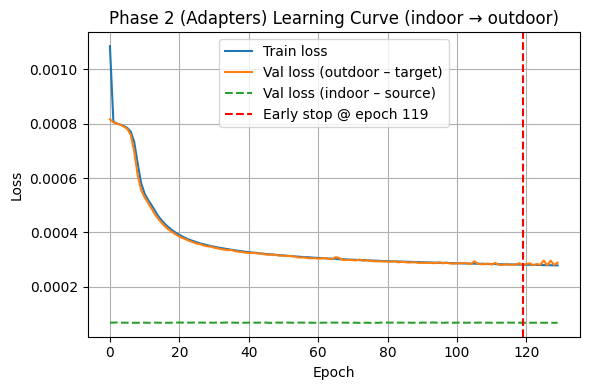

In [9]:
# ================================================
# Learning curve for DOMAIN-AWARE Phase 2 (Adapters)
# ================================================

# cross_type should be "in2out" or "out2in", same as in training
# ckpt_dir should be the same root checkpoint directory

# Reconstruct src/tgt names from cross_type (same logic as training)
if cross_type == "out2in":
    src_name = "outdoor"
    tgt_name = "indoor"
elif cross_type == "in2out":
    src_name = "indoor"
    tgt_name = "outdoor"
else:
    raise ValueError(f"Unknown cross_type: {cross_type}")

# Paths to saved curves
train_path = os.path.join(
    log_dir,
    f"train_losses_phase2_adapters_{src_name}_to_{tgt_name}.npy"
)
val_tgt_path = os.path.join(
    log_dir,
    f"val_losses_tgt_phase2_adapters_{src_name}_to_{tgt_name}.npy"
)
val_src_path = os.path.join(
    log_dir,
    f"val_losses_src_phase2_adapters_{src_name}_to_{tgt_name}.npy"
)

train_losses_phase2   = np.load(train_path)
val_losses_tgt_phase2 = np.load(val_tgt_path)
val_losses_src_phase2 = np.load(val_src_path)

# Load early-stopping epoch from Phase 2 (adapters) checkpoint
ckpt_phase2_path = os.path.join(
    ckpt_dir,
    f"csinet_domainaware_phase2_adapters_{src_name}_to_{tgt_name}.pt"
)
phase2_ckpt = torch.load(ckpt_phase2_path, map_location="cpu")
best_epoch_adapters = phase2_ckpt["epoch"]

best_val_tgt = val_losses_tgt_phase2[best_epoch_adapters]
best_val_src = val_losses_src_phase2[best_epoch_adapters]

print(f"[Adapters {src_name}→{tgt_name}] Best {tgt_name} val loss = {best_val_tgt:.4e} at epoch {best_epoch_adapters}")
print(f"[Adapters {src_name}→{tgt_name}] {src_name} val loss at that epoch = {best_val_src:.4e}")
print(f"[Adapters {src_name}→{tgt_name}] Final train loss = {train_losses_phase2[-1]:.4e}")
print(f"[Adapters {src_name}→{tgt_name}] Final {tgt_name} val loss = {val_losses_tgt_phase2[-1]:.4e}")
print(f"[Adapters {src_name}→{tgt_name}] Final {src_name} val loss = {val_losses_src_phase2[-1]:.4e}")

# Plot learning curves
plt.figure(figsize=(6, 4))
plt.plot(train_losses_phase2,   label="Train loss")
plt.plot(val_losses_tgt_phase2, label=f"Val loss ({tgt_name} – target)")
plt.plot(val_losses_src_phase2, label=f"Val loss ({src_name} – source)", linestyle="--")

# Vertical line for early stopping (best target)
plt.axvline(best_epoch_adapters, color="red", linestyle="--", linewidth=1.5,
            label=f"Early stop @ epoch {best_epoch_adapters}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Phase 2 (Adapters) Learning Curve ({src_name} → {tgt_name})")
plt.legend()
plt.grid(True)
plt.tight_layout()

fig_name = f"learning_curve_phase2_adapters_{src_name}_to_{tgt_name}.png"
plt.savefig(os.path.join(log_dir, fig_name))
plt.show()
